In [1]:
import igraph
import numpy as np

In [2]:
import collections
import torch
import cvx_ha

In [116]:
def to_sparse_transition(graph):
    edges = graph.get_edgelist()
    Z = collections.defaultdict(float)
    weights = list()
    for (v, u) in edges:
        Z[v] += 1
    for v, u in edges:
        weights.append(1/Z[v])
    csr_graph = torch.sparse_coo_tensor(np.asarray(edges).T, np.asarray(weights), torch.Size([graph.vcount(), graph.vcount()]))
    return csr_graph.float()

def setup_matrices(n, k=10):
    graph = igraph.Graph.Erdos_Renyi(n, (k-1.5)/2/n, directed=True)
    graph.add_edges(zip(range(graph.vcount()), range(graph.vcount())))
    print('mean degree:', np.mean(graph.degree()))
    P = to_sparse_transition(graph)
    x0 = torch.ones(n).div_(n).requires_grad_(True)
    return P, x0
Setup = collections.namedtuple('Setup', 'x,closure,reset')

def setup_experiment(n=None, k=10, P=None, damping=0.0):
    if P is None:
        P, x0 = setup_matrices(n=n, k=k)
    else:
        n = P.size(0)
        x0 = torch.ones(n).div_(n).requires_grad_(True)
    def closure():
        x1 = P.t().mm(x0[:,None]).t()[0]
        # https://en.wikipedia.org/wiki/PageRank#Damping_factor
        l2 = (damping/n+(1-damping)*x1-x0).pow(2).sum()
        l2.backward()
        return l2.item()
    start = x0.data.clone()
    def reset():
        x0.data.set_(start.clone())
    return Setup(x0, closure, reset)

In [20]:
import tqdm

In [73]:
def train_loop(iters, closure, opt, lr_policy, callback, vals):
    try:
        with tqdm.trange(iters) as range_:
            for i in range_:
                opt.zero_grad()
                if lr_policy is not None:
                    lr_policy.step(i)
                y = opt.step(closure)
                range_.set_description('loss: %.10f' % y)
                vals.append(y)
                if callback is not None:
                    callback(x, y, i)
    except KeyboardInterrupt:
        print('manually stopped')

In [22]:
def run_proj_sgd(x, closure, iters=1600, lr_policy=None, lr0=1., callback=None):
    vals = []
    opt = cvx_ha.ha1.ProjectedSGD([x], lr=lr0, projection=cvx_ha.ha1.simplex_projection)
    if lr_policy is not None:
        lr_policy = torch.optim.lr_scheduler.LambdaLR(opt, lr_policy)
    train_loop(iters, closure, opt, lr_policy, callback, vals)
    return np.asarray(vals)

def run_dual_averaging(x, closure, iters=1600, lr_policy=None, lr0=1., callback=None):
    vals = []
    opt = cvx_ha.ha1.DualAveraging([x], lr=lr0, dual_projection=cvx_ha.ha1.simplex_dual_projection)
    if lr_policy is not None:
        lr_policy = torch.optim.lr_scheduler.LambdaLR(opt, lr_policy)
    train_loop(iters, closure, opt, lr_policy, callback, vals)
    return np.asarray(vals)

# https://bayen.eecs.berkeley.edu/sites/default/files/conferences/efficient_bregman_projections.pdf
def run_mirror_bayen(x, closure, iters=1600, lr_policy=None, lr0=1., callback=None):
    vals = []
    opt = cvx_ha.ha1.MirrorDescent([x], lr=lr0, brehman_projection=cvx_ha.ha1.mirror_descent.brehman_exp_simplex_projection)
    if lr_policy is not None:
        lr_policy = torch.optim.lr_scheduler.LambdaLR(opt, lr_policy)
    train_loop(iters, closure, opt, lr_policy, callback, vals)
    return np.asarray(vals)

# https://blogs.princeton.edu/imabandit/2013/04/18/orf523-mirror-descent-part-iiii/
def run_mirror_prinston(x, closure, iters=1600, lr_policy=None, lr0=1., callback=None):
    vals = []
    def brehman_project(x, g):
        y = x*(-g).exp()
        return y.div_(y.norm(1))
    bh = cvx_ha.ha1.BregmanProjectionUpdate(closed_form=brehman_project)
    opt = cvx_ha.ha1.MirrorDescent([x], lr=lr0, brehman_projection=bh)
    if lr_policy is not None:
        lr_policy = torch.optim.lr_scheduler.LambdaLR(opt, lr_policy)
    train_loop(iters, closure, opt, lr_policy, callback, vals)
    return np.asarray(vals)

# Small problem

In [23]:
setup = setup_experiment(100, 5)

In [29]:
setup.reset()
results_mirror_bayen = run_mirror_bayen(setup.x, setup.closure, lr0=2)
setup.reset()
results_mirror_prinston = run_mirror_prinston(setup.x, setup.closure, lr0=2)
setup.reset()
results_sgd = run_proj_sgd(setup.x, setup.closure, lr0=1/(10*1600)**.5)
setup.reset()
results_dualavg = run_dual_averaging(setup.x, setup.closure, lr0=1/1600**.5)

loss: 0.0000: 100%|██████████| 1600/1600 [00:07<00:00, 209.41it/s]


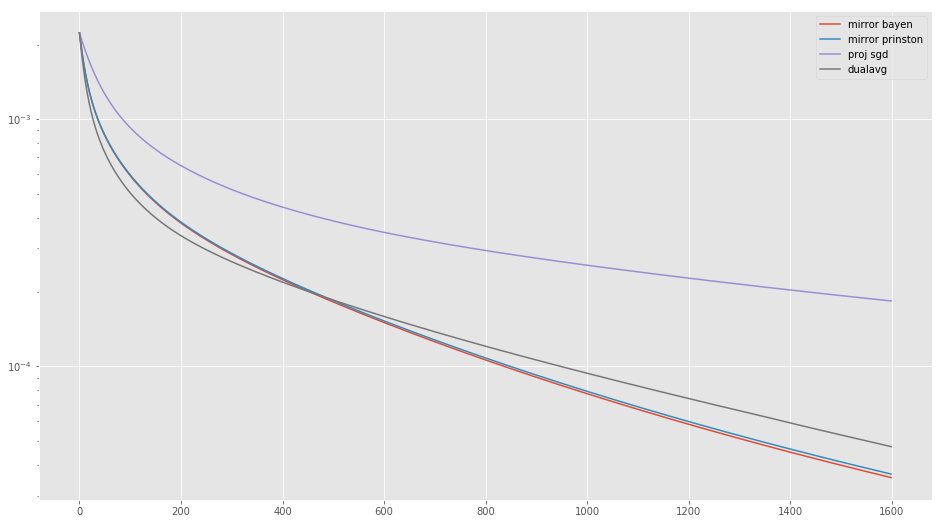

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 9))
plt.plot(results_mirror_bayen, label='mirror bayen')
plt.plot(results_mirror_prinston, label='mirror prinston')
plt.plot(results_sgd, label='proj sgd')
plt.plot(results_dualavg, label='dualavg')
plt.legend()
plt.yscale('log')

Here we see that most algorithms perform well with defaults

# Large problem
I will not run bayen mirror descent update implementation because it's slower

In [70]:
setup = setup_experiment(10**5, 20)

mean degree: 20.50176


In [71]:
setup.closure()

9.637477660362492e-07

In [144]:
setup.reset()
# strange but large lr works significantly better, no intuitoin so far
results_mirror_prinston = run_mirror_prinston(setup.x, setup.closure, lr0=1e3, iters=100)
setup.reset()
results_sgd = run_proj_sgd(setup.x, setup.closure, lr0=1/(10*1600)**.5, iters=100)
setup.reset()
results_dualavg = run_dual_averaging(setup.x, setup.closure, lr0=1/1600**.5, iters=100)

loss: 0.0000000095: 100%|██████████| 100/100 [00:47<00:00,  2.14it/s]


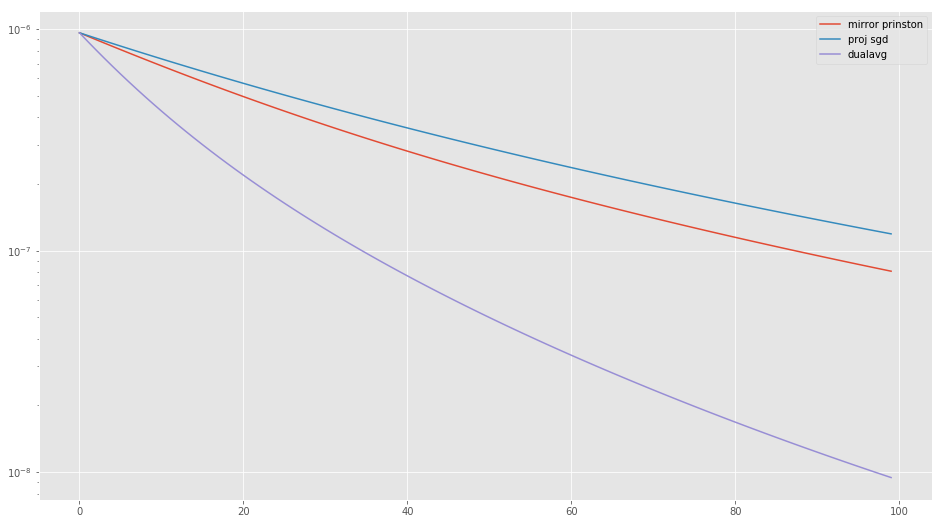

In [145]:
plt.figure(figsize=(16, 9))
plt.plot(results_mirror_prinston, label='mirror prinston')
plt.plot(results_sgd, label='proj sgd')
plt.plot(results_dualavg, label='dualavg')
plt.legend()
plt.yscale('log')

In [48]:
setup.reset()
results_mirror_prinston = run_mirror_prinston(setup.x, setup.closure, lr_policy=lambda t: 2*1/(1+t), iters=100)

loss: 0.0000009619: 100%|██████████| 100/100 [00:42<00:00,  2.33it/s]


In [38]:
!curl http://snap.stanford.edu/data/web-Google.txt.gz > web-Google.txt.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20.1M  100 20.1M    0     0   893k      0  0:00:23  0:00:23 --:--:-- 2281k


In [78]:
import gzip

In [100]:
def read_file_graph(path):
    edges = []
    seen = set()
    with gzip.open(path, 'r') as f:
        for row in f.readlines():
            if row.startswith(b'#'):
                continue
            source, target = row.split()
            edges.append((int(source), int(target)))
            seen.add(int(source))
            seen.add(int(target))
    Z = collections.defaultdict(float)
    weights = list()
    for (v, u) in edges:
        Z[v] += 1
    for v, u in edges:
        weights.append(1/Z[v])
    csr_graph = torch.sparse_coo_tensor(np.asarray(edges).T, np.asarray(weights), torch.Size([max(seen)+1, max(seen)+1]))
    return csr_graph.float()

In [101]:
google = read_file_graph('web-Google.txt.gz')

In [105]:
google.size()

torch.Size([916428, 916428])

In [106]:
google.type()

'torch.sparse.FloatTensor'

In [117]:
google_setup = setup_experiment(P=google, damping=0.1)

In [118]:
google_setup.closure()

4.878588515566662e-05

In [146]:
google_setup.reset()
# this is running on cpu
results_mirror_prinston = run_mirror_prinston(google_setup.x, google_setup.closure, lr0=1e3, iters=100)
x_prinston = google_setup.x.data.clone()

loss: 0.0000008498: 100%|██████████| 100/100 [04:27<00:00,  2.70s/it]


In [147]:
google_setup.reset()
# this is running on cpu
results_dual_averaging = run_dual_averaging(google_setup.x, google_setup.closure, lr0=1/200**.5, iters=100)
x_dual_averaging = google_setup.x.data.clone()

loss: 0.0000002999: 100%|██████████| 100/100 [05:16<00:00,  3.06s/it]


In [148]:
google_setup.reset()
# this is running on cpu
results_proj_sgd = run_proj_sgd(google_setup.x, google_setup.closure, lr0=1e-3, iters=100)
x_proj_sgd = google_setup.x.data.clone()

loss: 0.0000013759: 100%|██████████| 100/100 [05:10<00:00,  3.55s/it]


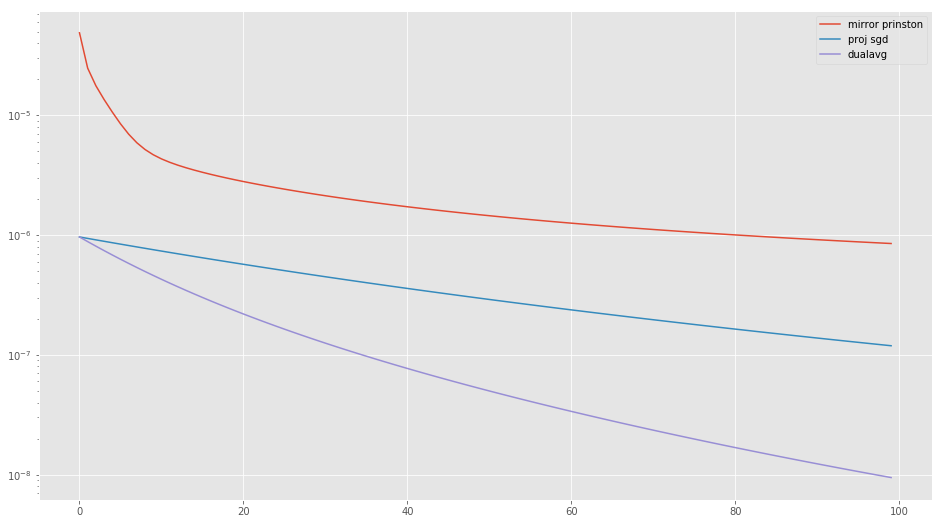

In [149]:
plt.figure(figsize=(16, 9))
plt.plot(results_mirror_prinston, label='mirror prinston')
plt.plot(results_sgd, label='proj sgd')
plt.plot(results_dualavg, label='dualavg')
plt.legend()
plt.yscale('log')

Dual averaging again was the best. Surplisingly
# How do we cook Mirror Descent?